In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import statsmodels.formula.api as smf

style.use("fivethirtyeight")
from google.colab import drive
drive.mount('/content/drive')

pd.set_option("display.max_columns", 99)
os.chdir("/content/drive/MyDrive/projects/ssc23-case-comp")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# load weather_prod data

weather_prod = pd.read_csv("./data/user_data/02_counterfactual_analysis/weather_prod_final.csv")

# column "is_flag" is 1 if extreme_flag is > 0, 0 otherwise
weather_prod["is_flag"] = np.where(weather_prod["extreme_flag"] > 0, 1, 0)
weather_prod["log_population"] = np.log(weather_prod["Population"])
print(weather_prod["is_flag"].value_counts())
weather_prod.head()

# There exists a class imbalance.

1    4147
0    1154
Name: is_flag, dtype: int64


,year,lat,lon,extreme_flag,tmax_flag,tmin_flag,total_flag,weather_station_name,provincename,X22.Utilities,X23.Construction,X31.33.Manufacturing,X48.49.Transportation.and.warehousing,X61.Educational.services,X62.Health.care.and.social.assistance,X72.Accommodation.and.food.services,X81.Other.services..except.public.administration.,X91.Public.administration,X11.Agriculture.forestry.fishing.hunting.21.Mining.quarrying.and.oil.and.gas.extraction,X41.Wholesale.trade.44.45.Retail.trade,X52.Finance.and.insurance.53.Real.estate.and.rental.and.leasing,X54.Professional..scientific.and.technical.services.55.56,X51.Information.culture.and.recreation.71,Population,is_flag,log_population
0,1998,51.68,-121.22,4,2,4,6,100 MILE HOUSE 6NE,British Columbia,10.361439,32.093841,52.577916,23.838820,13.957624,30.603084,14.542048,9.372471,21.056436,112.977398,41.419930,51.718541,26.429685,9.855601,16026.0,1,9.681968
1,1999,51.68,-121.22,4,3,4,7,100 MILE HOUSE 6NE,British Columbia,9.741119,36.176122,69.344267,23.798871,15.749157,30.793737,13.178521,9.012962,25.026848,123.018529,40.637891,52.895577,26.083535,10.734781,16026.0,1,9.681968
2,2000,51.68,-121.22,4,1,3,4,100 MILE HOUSE 6NE,British Columbia,11.995937,33.469164,70.027871,24.854750,15.246305,29.528441,14.411332,9.632571,24.517432,116.606455,42.747333,57.466138,25.759258,11.525466,16026.0,1,9.681968
3,2001,51.68,-121.22,6,4,4,8,100 MILE HOUSE 6NE,British Columbia,7.206688,32.891360,60.547691,22.637911,14.543792,30.715144,14.364507,10.064814,24.044517,123.989857,44.845824,56.587092,25.813853,12.416620,16026.0,1,9.681968
4,2002,51.68,-121.22,7,6,4,10,100 MILE HOUSE 6NE,British Columbia,11.136357,34.677476,64.053243,23.875227,14.133696,31.607435,12.331232,9.222107,25.911795,134.438545,48.734529,59.611726,25.939530,12.531136,16026.0,1,9.681968


In [5]:
# load covariates, filter out month == 12

covar_df = pd.read_csv("./data/user_data/_covariates/ppi_and_usd_imputed.csv")
covar_df = covar_df.loc[covar_df["month"] == 12, :].drop(columns = ["date", "month"]).reset_index(drop = True)
covar_df.head()

# Here, we take the top 3 PCA components from covar_df
# - Perform PCA
from sklearn.decomposition import PCA
n_pca = 5
pca = PCA(n_components=n_pca)
pca.fit(covar_df.drop(columns = ["year"]))
print(np.sum(pca.explained_variance_ratio_)) # 5PCs explain 96% of the variance in the data
covar_pca = pd.DataFrame(pca.transform(covar_df.drop(columns = ["year"])), columns = ["cPC" + str(i) for i in range(1, n_pca+1)])

# - Add year column back
covar_pca = pd.concat([covar_df.loc[:, "year"], covar_pca], axis = 1)
covar_pca.head()

0.9855814460304517


,year,cPC1,cPC2,cPC3,cPC4,cPC5
0,1997,-92.579974,24.207571,8.105888,12.309557,-2.077663
1,1998,-101.686713,34.730179,2.665244,8.314207,-4.655791
2,1999,-82.665395,15.011440,10.767730,-5.855812,5.847586
3,2000,-68.977272,1.599162,1.956627,-3.459779,17.768323
4,2001,-78.104870,19.400452,-0.719773,2.518907,5.708223


In [6]:
# merge covar_pca to weather_prod by year
weather_prod_df = pd.merge(weather_prod, covar_pca, on = "year", how = "left")
weather_prod_df.head()

,year,lat,lon,extreme_flag,tmax_flag,tmin_flag,total_flag,weather_station_name,provincename,X22.Utilities,X23.Construction,X31.33.Manufacturing,X48.49.Transportation.and.warehousing,X61.Educational.services,X62.Health.care.and.social.assistance,X72.Accommodation.and.food.services,X81.Other.services..except.public.administration.,X91.Public.administration,X11.Agriculture.forestry.fishing.hunting.21.Mining.quarrying.and.oil.and.gas.extraction,X41.Wholesale.trade.44.45.Retail.trade,X52.Finance.and.insurance.53.Real.estate.and.rental.and.leasing,X54.Professional..scientific.and.technical.services.55.56,X51.Information.culture.and.recreation.71,Population,is_flag,log_population,cPC1,cPC2,cPC3,cPC4,cPC5
0,1998,51.68,-121.22,4,2,4,6,100 MILE HOUSE 6NE,British Columbia,10.361439,32.093841,52.577916,23.838820,13.957624,30.603084,14.542048,9.372471,21.056436,112.977398,41.419930,51.718541,26.429685,9.855601,16026.0,1,9.681968,-101.686713,34.730179,2.665244,8.314207,-4.655791
1,1999,51.68,-121.22,4,3,4,7,100 MILE HOUSE 6NE,British Columbia,9.741119,36.176122,69.344267,23.798871,15.749157,30.793737,13.178521,9.012962,25.026848,123.018529,40.637891,52.895577,26.083535,10.734781,16026.0,1,9.681968,-82.665395,15.011440,10.767730,-5.855812,5.847586
2,2000,51.68,-121.22,4,1,3,4,100 MILE HOUSE 6NE,British Columbia,11.995937,33.469164,70.027871,24.854750,15.246305,29.528441,14.411332,9.632571,24.517432,116.606455,42.747333,57.466138,25.759258,11.525466,16026.0,1,9.681968,-68.977272,1.599162,1.956627,-3.459779,17.768323
3,2001,51.68,-121.22,6,4,4,8,100 MILE HOUSE 6NE,British Columbia,7.206688,32.891360,60.547691,22.637911,14.543792,30.715144,14.364507,10.064814,24.044517,123.989857,44.845824,56.587092,25.813853,12.416620,16026.0,1,9.681968,-78.104870,19.400452,-0.719773,2.518907,5.708223
4,2002,51.68,-121.22,7,6,4,10,100 MILE HOUSE 6NE,British Columbia,11.136357,34.677476,64.053243,23.875227,14.133696,31.607435,12.331232,9.222107,25.911795,134.438545,48.734529,59.611726,25.939530,12.531136,16026.0,1,9.681968,-59.568083,7.717234,5.706225,5.469294,7.785224


## Propensity score weighting.

* Here, we compute the propensity score $P(T = 1 | X)$ where:
  *  $T = 1$ if is_flag = True, 0 otherwise.
  *  $X$ is a set of covariates we want to adjust for, which includes:
     *  year, population, location (lat, lon), cPCs (USD currency, oil price, commodity prices)
  *  Fit logistic regression model to predict $T$ from $X$.
  *  Use propensity score weighting to compute the treatment effect, adjusting for covariates.
  *  Use bootstrap sampling to compute the mean and standard error of the average treatment effect (ATE) of extreme weather on the log(production).
*  The advantage of propensity score weighting is that we can utilize all samples in the dataset, unlike in matching-based methods.
*  In this notebook we consider X11.Agriculture.forestry.fishing.hunting.21.Mining.quarrying.and.oil.and.gas.extraction as an example.

In [7]:
# Use logistic regression to predict is_flag
from sklearn.linear_model import LogisticRegression

prod_cols = weather_prod.columns[6:20].tolist()
print(prod_cols)
covar_cols = ["year", "Population", "lat", "lon", "cPC1", "cPC2", "cPC3", "cPC4", "cPC5"]

T = "is_flag"
Y = prod_cols[9] # X11.Agriculture.forestry.fishing.hunting.21.Mining.quarrying.and.oil.and.gas.extraction
X = covar_cols

df_sub = weather_prod_df.loc[:, [T, Y] + X].dropna()
df_sub["log_prod"] = np.log(df_sub[Y] + 1)
Y = "log_prod"

ps_model = LogisticRegression(C=1e6).fit(df_sub[X], df_sub[T]) # C is the inverse of regularization strength for L2
data_ps = df_sub.assign(propensity_score = ps_model.predict_proba(df_sub[X])[:, 1])
print(data_ps[["is_flag", Y, "propensity_score"]].sample(5))


['total_flag', 'weather_station_name', 'provincename', 'X22.Utilities', 'X23.Construction', 'X31.33.Manufacturing', 'X48.49.Transportation.and.warehousing', 'X61.Educational.services', 'X62.Health.care.and.social.assistance', 'X72.Accommodation.and.food.services', 'X81.Other.services..except.public.administration.', 'X91.Public.administration', 'X11.Agriculture.forestry.fishing.hunting.21.Mining.quarrying.and.oil.and.gas.extraction', 'X41.Wholesale.trade.44.45.Retail.trade']
      is_flag  log_prod  propensity_score
3133        0  5.627319          0.795906
291         1  0.623466          0.777564
4834        1  2.563096          0.778167
139         1  2.358873          0.778474
4237        1  2.182407          0.778541


In [8]:
# - By producing weights 1/P(T|X), it creates the population where everyone is treated,
#   and 1/(1-P(T|X)) creates the population where everyone is untreated.

weight_t = 1/data_ps.query("is_flag==1")["propensity_score"]
weight_nt = 1/(1 - data_ps.query("is_flag==0")["propensity_score"])
print("original sample size", df_sub.shape[0])
print("extreme_temp size", sum(weight_t))
print("non extreme_temp size", sum(weight_nt))

original sample size 5301
extreme_temp size 5301.263012120515
non extreme_temp size 5294.883865339114


<ipython-input-11-67b6edfba165>:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_ps.query("is_flag==0")["propensity_score"], kde=False, label="Non-extreme temp.")
<ipython-input-11-67b6edfba165>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data_ps.query("is_flag==1")["propensity_score"]

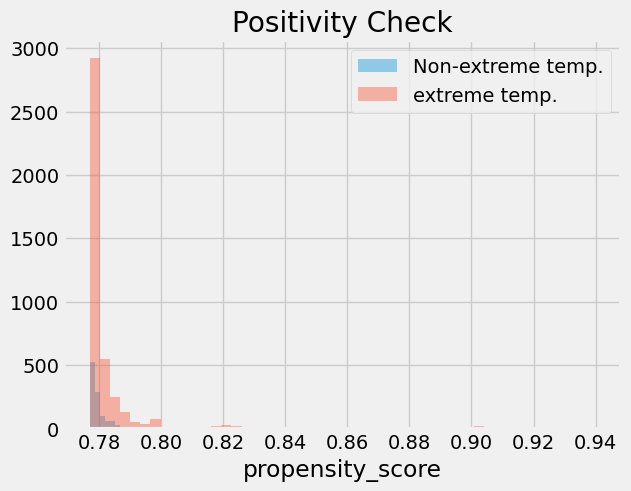

In [11]:
# - Check the empirical distribution of the propensity score on the treated and the untreated.
sns.distplot(data_ps.query("is_flag==0")["propensity_score"], kde=False, label="Non-extreme temp.")
sns.distplot(data_ps.query("is_flag==1")["propensity_score"], kde=False, label="extreme temp.")
plt.title("Positivity Check")
plt.legend();
#  * Here we see that we can find both extreme and non-extreme temp. nicely overlap with each other, i.e., balanced.

In [12]:
# - Finally, use the propensity score to estimate the average treatment effect.
weight = ((data_ps["is_flag"] - data_ps["propensity_score"]) / 
          (data_ps["propensity_score"] * (1 - data_ps["propensity_score"])))
y1 = sum(data_ps.query("is_flag==1")[Y] * weight_t) / len(df_sub)
y0 = sum(data_ps.query("is_flag==0")[Y] * weight_nt) / len(df_sub)

ate = np.mean(weight * data_ps[Y])

print("Y1:", y1)
print("Y0:", y0)
print("Average treatment effect (ATE)", ate)

Y1: 2.8535036165166914
Y0: 2.7935945948096728
Average treatment effect (ATE) 0.05990902170702532


In [13]:
# Standard error

from joblib import Parallel, delayed # for parallel processing

# define function that computes the IPTW estimator
def run_ps(df, X, T, y):
    # estimate the propensity score
    ps = LogisticRegression(C=1e6).fit(df[X], df[T]).predict_proba(df[X])[:, 1]
    
    weight = (df[T]-ps) / (ps*(1-ps)) # define the weights
    return np.mean(weight * df[y]) # compute the ATE

np.random.seed(88)

# run 1000 bootstrap samples
bootstrap_sample = 100
ates = Parallel(n_jobs=4)(delayed(run_ps)(df_sub.sample(frac=1, replace=True), X, T, Y)
                          for _ in range(bootstrap_sample))
ates = np.array(ates)

mean(ATE): 0.05021968373958614
se(ATE): 0.04828858097815503
95% C.I.: (-0.03332687313932225, 0.13506312204944781)


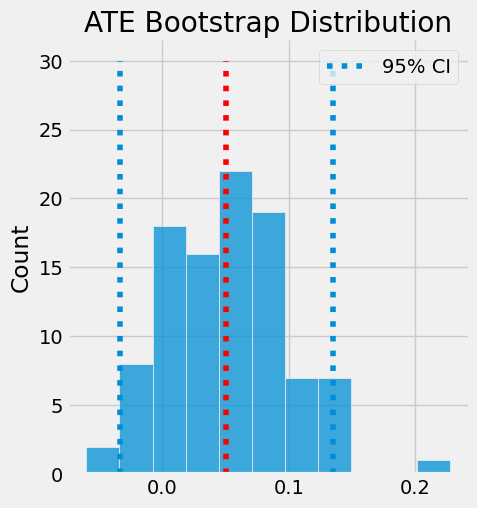

In [14]:
# - The ATE is then the mean of the bootstrap samples, and CI is the 2.5% and 97.5% quantiles of the bootstrap samples.
print(f"mean(ATE): {ates.mean()}")
print(f"se(ATE): {ates.std()}")
print(f"95% C.I.: {(np.percentile(ates, 2.5), np.percentile(ates, 97.5))}")


sns.displot(ates, kde=False)
plt.vlines(x = ates.mean(), ymin = 0, ymax = 30, linestyles="dotted", colors= "red")
plt.vlines(np.percentile(ates, 2.5), 0, 30, linestyles="dotted")
plt.vlines(np.percentile(ates, 97.5), 0, 30, linestyles="dotted", label="95% CI")
plt.title("ATE Bootstrap Distribution")
plt.legend();